In [1]:
import os
from os import listdir
from os.path import isfile, join, isdir
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path


#sns.set(rc={'figure.figsize':(12,8)})
sns.set(rc={'figure.figsize':(8,4.6)})
palette= sns.color_palette("Dark2")
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context("talk")

import pickle
import sys
sys.path.insert(1,'/usr3/graduate/baksar/projectx/E2EWatch/utils/')
from config import Configuration

# sys.path.insert(1,'/usr3/graduate/baksar/projectx/ADF-Deployment/utils/')
# from utils import *
# from config import Configuration

In [2]:
def readModelConfig(exp_name,cv_index,model_name,system):
    """Reads saved config file and returns as a dictionary"""
    
    import math    
    config_path = Path('/projectnb/peaclab-mon/aksar/models/DeploymentModels/{system}/{exp_name}/CV_{cv_index}/{model_name}/model_config.csv'.format(system=system,exp_name=exp_name,cv_index=cv_index,model_name=model_name))
    
    conf = {}
    try:
        conf_csv = pd.read_csv(config_path)
    except:
        logging.info("Config.csv doesn't exist")
    

    for column in conf_csv.columns:
        
        if isinstance(conf_csv[column][0],str):
            if 'dir' in column:
                conf[column] = Path(conf_csv[column][0])
            else:
                conf[column] = conf_csv[column][0]
                
        #FIXME: Find a generic comparison for integers
        elif isinstance(conf_csv[column][0],np.int64):
                conf[column] = conf_csv[column][0]  
                
        elif isinstance(conf_csv[column][0],np.bool_):
                conf[column] = conf_csv[column][0]                  
        else:
            if math.isnan(conf_csv[column][0]):
                conf[column] = None
        
    return conf

In [3]:
def calc_conf_for_each_anom(conf_df):
    
    anom_pred_conf = pd.DataFrame()
    cv_num = 0            
    unique_anoms = list(conf_df['Anomaly'].unique())
    
    for anom in unique_anoms:     
        
        if anom_pred_conf.empty:
            anom_pred_conf['Prediction Confidence'] = conf_df[conf_df['Anomaly'] == anom]['Prediction Confidence'].values
            anom_pred_conf['Anomaly'] = anom
        else:
            temp_df = pd.DataFrame()
            temp_df['Prediction Confidence'] = conf_df[conf_df['Anomaly'] == anom]['Prediction Confidence'].values
            temp_df['Anomaly'] = anom
            anom_pred_conf = anom_pred_conf.append(temp_df)

    return anom_pred_conf    

In [4]:
#CV_FOLDS = [0,1,2,3,4]
CV_FOLDS = [0]

MODEL_NAME = 'random_forest' 
MODEL = 'lgbm' 
FS = 1
SYSTEM = 'eclipse'
#EXP_NAME = 'eclipse_verification_sampled'

#EXP_NAME = 'final_window_10min'
#EXP_NAME = 'final_window_5min'
#EXP_NAME = 'tpds_window_45sec'
EXP_NAME = 'final_window_60sec'
#EXP_NAME = 'final_window_5min'
#EXP_NAME = 'final_window_45sec'


if FS:
    MODEL += '-fs' 

In [5]:
for cv_index in CV_FOLDS:   
    
    model_config = readModelConfig(exp_name=EXP_NAME,cv_index=cv_index,model_name=MODEL_NAME,system=SYSTEM)   

In [6]:
with open(model_config['results_dir'] / "{}_pred_confidence.pickle".format(MODEL),'rb') as f:
    confidence_df = pickle.load(f)
anom_pred_conf = calc_conf_for_each_anom(confidence_df)    
qual = anom_pred_conf.groupby("Anomaly").agg([np.mean, np.std]) 
qual = qual['Prediction Confidence']

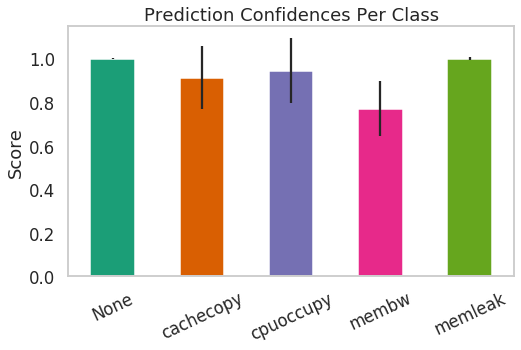

In [8]:
ax = qual.plot(kind = "bar", y = "mean", 
                  legend = False, 
                  yerr = "std", 
                  title = "", 
                  #cmap = my_cmap,
                  color=palette,
          )

ax.set_title('Prediction Confidences Per Class')
ax.set_xticklabels(labels=qual.index,rotation=25)
ax.set_xlabel('')
ax.set_ylabel('Score')
plt.savefig(model_config['plots_dir'] / 'classifier_confidences.pdf',bbox_inches='tight')

In [15]:
df_std = anom_pred_conf.groupby('Anomaly').std()
df_std.rename(columns={'Prediction Confidence':'std'},inplace=True)
df_mean = anom_pred_conf.groupby('Anomaly').mean()
df_mean.rename(columns={'Prediction Confidence':'mean'},inplace=True)
pd.concat([df_std,df_mean],axis=1).to_csv(model_config['results_dir'] / '{}_average_pred_confs.csv'.format(MODEL))

In [16]:
data = [[ 66386, 174296,  75131, 577908,  32015],
        [ 58230, 381139,  78045,  99308, 160454],
        [ 89135,  80552, 152558, 497981, 603535],
        [ 78415,  81858, 150656, 193263,  69638],
        [139361, 331509, 343164, 781380,  52269]]
columns = ('Freeze', 'Wind', 'Flood', 'Quake', 'Hail')
rows = ['%d year' % x for x in (100, 50, 20, 10, 5)]

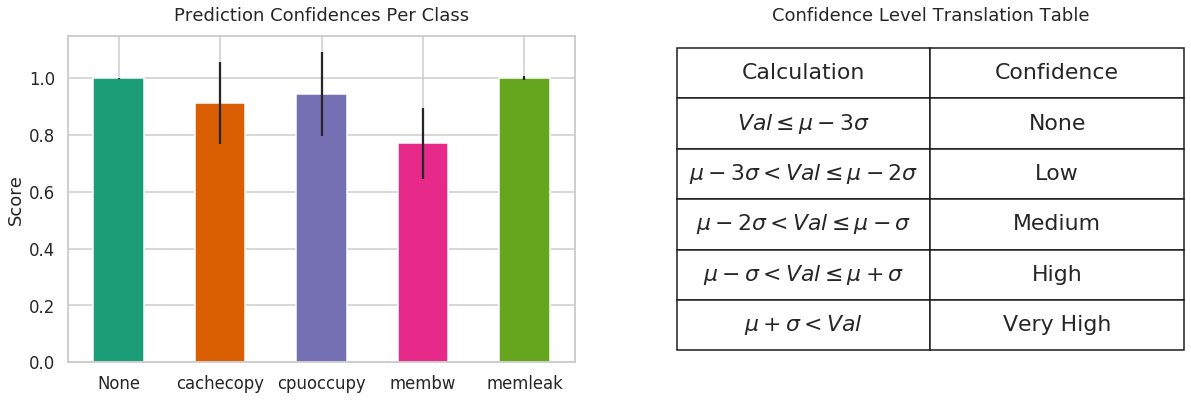

In [10]:
fig, ax = plt.subplots(1,2,figsize=(20, 6),)

qual.plot(kind = "bar", y = "mean", 
                  legend = False, 
                  yerr = "std", 
                  title = "", 
                  ax = ax[0],
                  #cmap = my_cmap,
                  color=palette,
          )

ax[0].set_title('Prediction Confidences Per Class',pad=15)
ax[0].set_xticklabels(labels=qual.index,rotation=0)
ax[0].set_xlabel('')
ax[0].set_ylabel('Score')

# hide axes
fig.patch.set_visible(False)
ax[1].axis('off')
ax[1].axis('tight')
ax[0].grid()

data = np.array([['$ Val\leq\mu-3\sigma$',"None"],
                 ['$\mu-3\sigma<Val\leq\mu-2\sigma$',"Low"],
                 ['$\mu-2\sigma<Val\leq\mu-\sigma$','Medium'],
                 ['$\mu-\sigma<Val\leq\mu+\sigma$','High'],
                 ['$ \mu+\sigma<Val$','Very High']])

tab1 = ax[1].table(cellText=data, colLabels=['Calculation','Confidence'],cellLoc='center' ,loc='center')
tab1.set_fontsize(22)
tab1.auto_set_font_size(False)
tab1.scale(1, 4.2)
ax[1].set_title('Confidence Level Translation Table',pad=15)

#fig.tight_layout()

#plt.show()
plt.savefig(model_config['plots_dir'] / 'classifier_confidences.pdf',bbox_inches='tight')

In [ ]:
#plot_anom_conf(anom_pred_conf,model_config)

In [117]:
#def plot_anom_conf(data,conf):
    
#     palette= sns.color_palette("tab10")
#     sns.set(rc={'figure.figsize':(8,4.6)})

#     sns.set_style("whitegrid")
#     sns.set_context("talk")    
    
#     #You might need to modify this according to 
#     anom_order = ['None','memleak','cachecopy','cpuoccupy','membw']

#     ax = sns.boxplot(x='Anomaly',y='Prediction Confidence',
#                      order = anom_order,
#                      palette= palette,
#                      #showfliers=False,
#                      data=data) 
#     ax.set_title('Prediction Confidences Per Class')
#     ax.set_xlabel('')

#     std_dict = {}
#     stds = data.groupby('Anomaly').std()
#     for anom in stds.index:
#         std_dict[anom] = round(stds.loc[anom][0],2)

#     textstr = '\n'.join((
#         r'$\sigma_{None}=%.2f$' % (std_dict['None'], ),
#         r'$\sigma_{memleak}=%.2f$' % (std_dict['memleak'], ),
#         r'$\sigma_{cachecopy}=%.2f$' % (std_dict['cachecopy'], ),
#         r'$\sigma_{cpuoccupy}=%.2f$' % (std_dict['cpuoccupy'], ),
#         r'$\sigma_{membw}=%.2f$' % (std_dict['membw'], ),

#     ))            

#     ax = plt.axes()      

#     props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)    

#     ax.text(0.02, 0.45, textstr, transform=ax.transAxes, fontsize=14,
#             verticalalignment='top', bbox=props) 
    
#     plt.savefig(model_config['plots_dir'] / 'classifier_confidences.pdf',bbox_inches='tight')

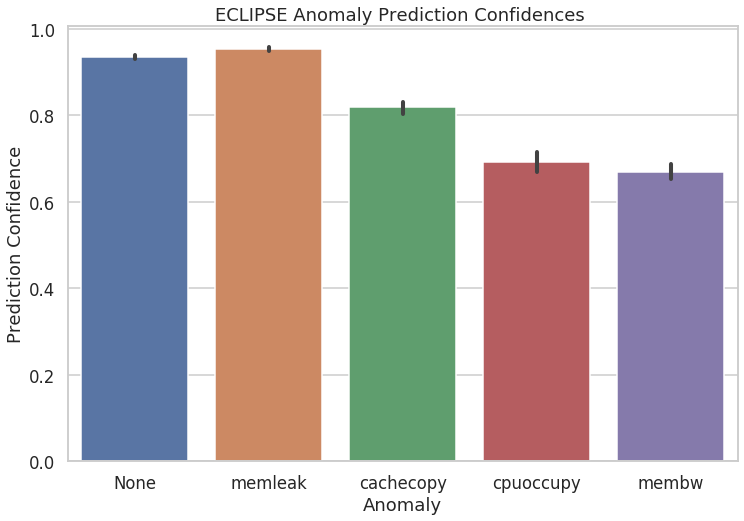

In [86]:
cv_0_confs = calc_pred_conf_CV(conf,'CV_0')
plot_conf_CV(cv_0_confs)

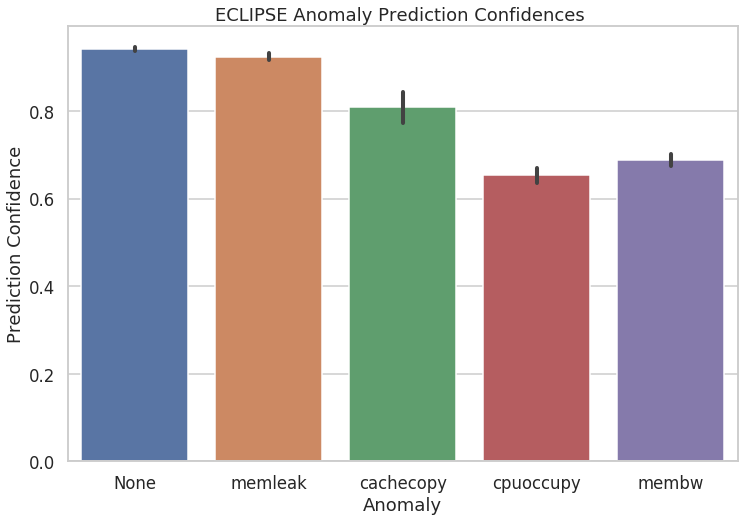

In [87]:
cv_1_confs = calc_pred_conf_CV(conf,'CV_1')
plot_conf_CV(cv_1_confs)

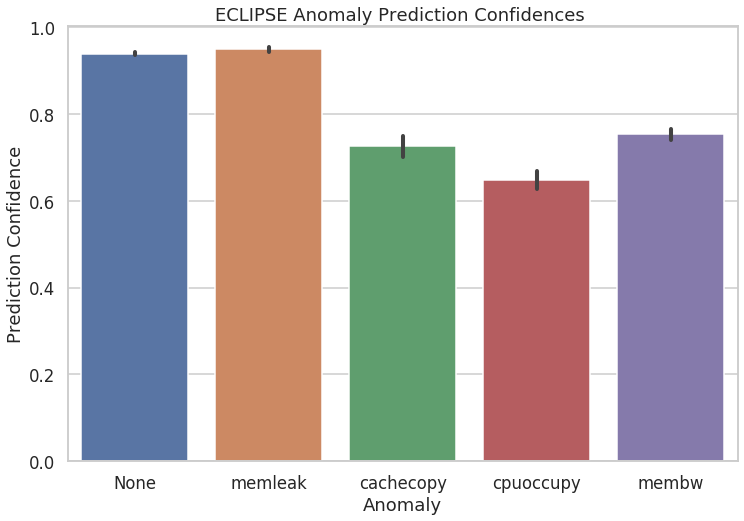

In [88]:
cv_2_confs = calc_pred_conf_CV(conf,'CV_2')
plot_conf_CV(cv_2_confs)

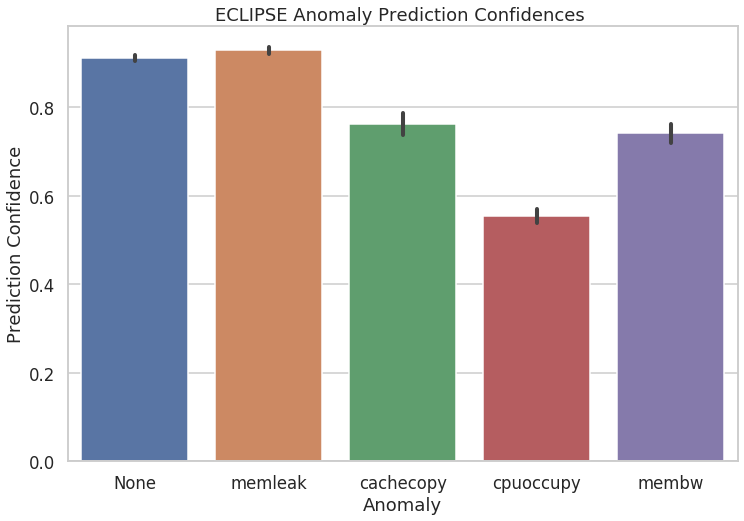

In [89]:
cv_3_confs = calc_pred_conf_CV(conf,'CV_3')
plot_conf_CV(cv_3_confs)

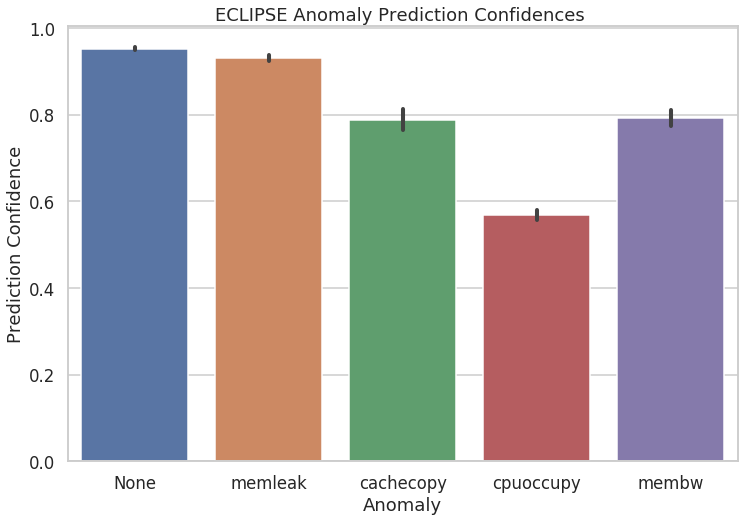

In [90]:
cv_4_confs = calc_pred_conf_CV(conf,'CV_4')
plot_conf_CV(cv_4_confs)

In [76]:
anom_pred_conf

,Prediction Confidence,Anomaly
0,0.94,None
1,0.99,None
2,1.00,None
3,0.99,None
4,0.98,None
...,...,...
165,0.95,cachecopy
166,0.95,cachecopy
167,0.95,cachecopy
168,0.95,cachecopy


/project/peaclab-mon/pyenv/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


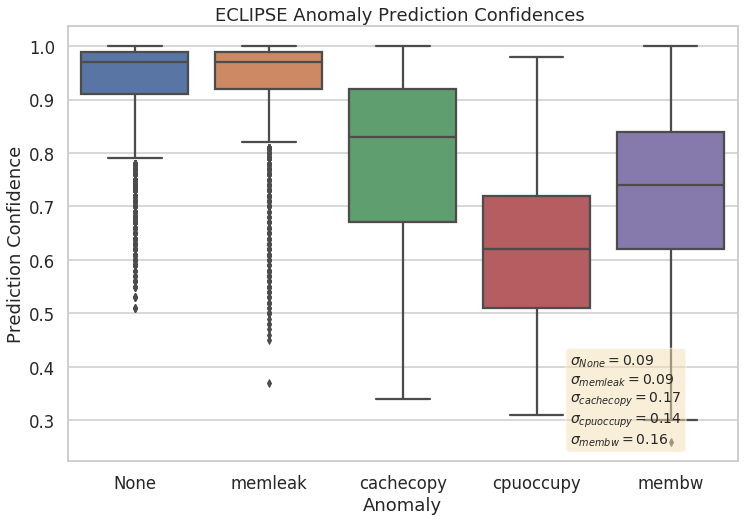

In [120]:
anom_pred_conf = calc_conf_for_each_anom(conf)
plot_anom_conf(anom_pred_conf)

In [11]:
#Calculate average and std of prediction confidences
average_pred_conf = calc_average_conf(conf)
average_pred_conf

,mean,std
anomaly,,
None,0.935944,0.082161
cachecopy,0.780976,0.162359
cpuoccupy,0.623220,0.124976
membw,0.729038,0.154709
memleak,0.937289,0.086403


In [ ]:
average_pred_conf.to_csv(conf['config_dir'] / 'average_pred_confs.csv')